# Notebook 2: Tokenization and normalization

In this notebook we dive deeper into the tokenization and normalization of witnesses.

Remember the Gothenburg model of automated collation?  

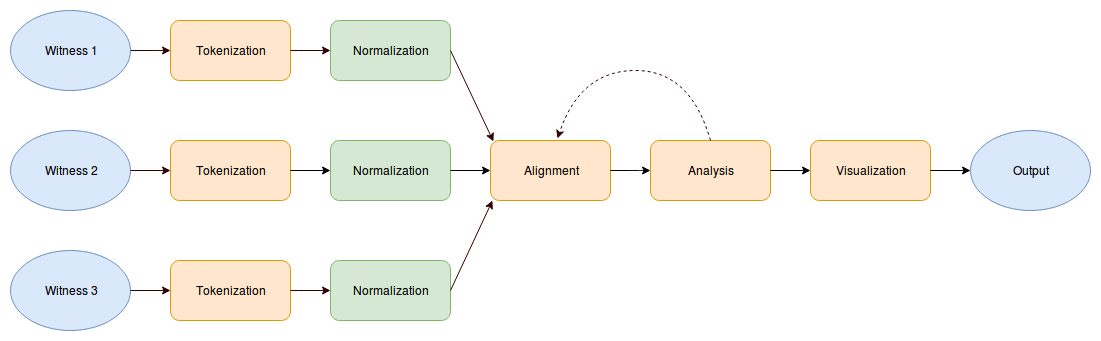

To recap: the model was [established](https://collatex.net/doc/) in 2011 by a group of developers and scholars who divided the collation process into separate components. These components form subsequent steps, with the output of one step providing the input of the next. By agreeing on this modular structure they could collaborate more easily, and finetune the development of individual components.  

The model also helps scholars to reflect on the collation of their own texts. Once you know which steps the software CollateX takes by default, you can estimate whether you may want to change some parameters to better handle the particularities of your material.



So what are the default (built-in) settings of CollateX?  
- Input witnesses are **tokenized** on whitespace. This is the blank space punctuation in text, here represented as `_`;
- Punctuation marks are considered their own tokens;
- For each token, trailing whitespace is **normalized** and thus ignored by the aligner; 
- Uppercase and lowercase letters are considered different.

This means, for example, that the tokens `cat` and `cat_` are considered as equal (= a match) by the alignment algortihm.   

So far, that's relatively simple. But you may want to consider additional normalization options, for example:
- **Lower and upper case**: e.g., `Cat` will be matched with `cat`;
- **Graphemes**: e.g, the Latin alphabet regular `s` will be matched with the long `ſ`;
- **Orthographic variation**: e.g., the British spelling `honour` will be matched with the American `honor`;
- **Morphological variation**: e.g., inflected forms of a verb, like `is` and `are` will be considered a match;
- **Lexical variation**: e.g., `journals` will be aligned with `magazines`.

The choices you make here depend on the purpose of your collation. The choices may even vary in different stages of the same project.



# Tokenization

By default, CollateX consideres punctuation marks as separate tokens. This means that the input `Elli's dog` will be tokenized as four tokens: `Elli`, `'`, `s`, and '`dog`. 

In [20]:
from collatex import *
collation = Collation()
collation.add_plain_witness("A", "Elli's dog.")
collation.add_plain_witness("B", "Elli's puppy.")
table = collate(collation, segmentation=False)
print(table)

+---+------+---+---+-------+---+
| A | Elli | ' | s | dog   | . |
| B | Elli | ' | s | puppy | . |
+---+------+---+---+-------+---+


In some cases, this may not be what you want. For example, when the apostrophe is not a possessive but a contraction, as with ``Wouter doesn't have a dog."

In [21]:
collation = Collation()
collation.add_plain_witness("A", "Wouter doesn't have a dog.")
collation.add_plain_witness("B", "Wouter does not have a dog.")
table = collate(collation, segmentation=False)
print(table)

+---+--------+-------+-----+---+------+---+-----+---+
| A | Wouter | doesn | '   | t | have | a | dog | . |
| B | Wouter | does  | not | - | have | a | dog | . |
+---+--------+-------+-----+---+------+---+-----+---+


In such cases, you may want to override the default settings of CollateX. Let's take a closer look how we can do that.

## Doing your own tokenization
Building upon the example above, let's create a tokenization where we 
1. split a string into tokens on white space;
2. create separat tokens for final punctuation (but not internal).

1. Splitting on white space

In [22]:
input = "Wouter's dog."

In [23]:
# import regular expressions
import re
words = re.split(r'\s+', input)
print(words)

["Wouter's", 'dog.']


So now we have tokenized on whitespace only. Let's make sure that final punctuation marks are treated as a separate token, without splitting on internal punctuation.

In [25]:
tokens = [re.findall(r'.+\w|\W+$', word) for word in words]
print(tokens)

[["Wouter's"], ['dog', '.']]


With this regular expression we have defined a token as either a string of any characters that ends in a word character or a string of non-word characters. As a result, `Wouter's` is considered as one token, because it ends with an "s" (a word character) and "dog." is separated into two tokens because it doesn't end on a word character.

Who can tell me in what type of data structure the variable `tokens` is?

We will want to unpack that:

In [26]:
import re
input = "Wouter's dog."
words = re.split(r'\s+', input)
tokens_by_word = [re.findall(r'.+\w|\W+$', word) for word in words]
tokens = []
for item in tokens_by_word:
    tokens.extend(item)
print(tokens)

["Wouter's", 'dog', '.']


## Creating the input for CollateX

### Dictionaries

CollateX expects our custom tokenized witnesses not as lists of strings, but in the form of a Python dictionary:

`{"witnesses" : [ witness_a, witness_b ] }`.

Each witness, in turn, is also a Python dictionary with exactly two properties:  

`witness_a = { "id" : "A", "tokens" : tokens_a }`  

The keys of the properties are "id" and "tokens"; the values of the properties are the siglim of the witness (here the string "A") and a list of tokens to be aligned (here referred to with the variable `tokens_a`).

Each token in a witness is also a dictionary with at least one property: "t" (for "text"). So a token for the string "dog" would look as follows:  
`{ "t" : "dog" }`  

The list of tokens for our example witness "Wouter's dog" would look as follows:  

### Collating our tokenized witnesses
Remember we had a list of tokens? 

In [32]:
print(tokens)

["Wouter's", 'dog', '.']


Let's transform the list into a list of dictionaries that CollateX requires as input for each witness:

In [28]:
token_list = [{"t" : token} for token in tokens]
print(token_list)

[{'t': "Wouter's"}, {'t': 'dog'}, {'t': '.'}]


And finally, let's create a function for this tokenization:

In [33]:
from collatex import *
import re

def tokenize(input):
    words = re.split(r'\s+', input) # split input on whitespace
    tokens_by_word = [re.findall(r'.+\w|\W$', word) for word in words] # split on final punctuation
    tokens = []
    for item in tokens_by_word:
        tokens.extend(item)
    token_list = [{"t" : token} for token in tokens] # create dictionaries for each token
    return token_list

input_a = "Wouter's dog."
input_b = "Wouter's cat."

tokens_a = tokenize(input_a)
tokens_b = tokenize(input_b)
witness_a = {"id" : "A", "tokens" : tokens_a }
witness_b = {"id": "B", "tokens" : tokens_b }
input = {"witnesses" : [ witness_a, witness_b ]}
table = collate(input, segmentation=False)
print(table)


+---+----------+-----+---+
| A | Wouter's | dog | . |
| B | Wouter's | cat | . |
+---+----------+-----+---+


## Up to you!